In [1]:
import torch
import torchvision
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
from torch.nn import functional 
from pydub import AudioSegment
import librosa

In [2]:
MAPPING = {
    "acoustic" : 0,
    "blues" : 1,
    "classical" : 2,
    "country" : 3,
    "dance" : 4,
    "edm" : 5,
    "hip-hop" : 6,
    "indie" : 7,
    "jazz" : 8,
    "pop" : 9,
    "rock" : 10,
    "world-music" : 11
}

# Declare modified EfficientNet
efnet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
efnet_model = torchvision.models.efficientnet_b0(weights = efnet_weights)

# Alter Efnet to receive 4 channels (RGBY) instead of 3 (RGB)
efnet_model.features[0][0] = torch.nn.Conv2d(4, 32, 
                                             kernel_size=(3, 3),
                                             padding=(1, 1), bias=False)

# Use Feature Extraction
for param in efnet_model.features.parameters():
    param.requires_grad = False

# Replace the "classifier" layer with one for our application
num_cats = len(MAPPING) # 12
efnet_model.classifier = torch.nn.Sequential( 
    torch.nn.Linear(in_features=1280, out_features=num_cats, bias=True)
)

In [3]:
SAVED_MODEL_PATH = 'saved_models/'
# Load saved net
loaded_net = efnet_model
loaded_net.load_state_dict(torch.load(SAVED_MODEL_PATH + 'net-transfer-epochs100-lrate0.01-cropped.pth'))
loaded_net.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [4]:
# Functions to make predictions on a single input 

CATEGORY_LABEL = ["acoustic", "blues", "classical", "country","dance","edm",
                  "hip-hop","indie","jazz","pop","rock","world-music"]

def generate_one_spectrogram(input_filename):
    TEST_PATH = 'test_files/'

    ### Generate spectrogram
    src = TEST_PATH + input_filename + '.mp3'
    dst = TEST_PATH + input_filename + '.wav'
                                 
    sound = AudioSegment.from_mp3(src)
    sound.export(dst, format="wav")

    SAMPLE_RATE = 22050
    y, sr = librosa.load(dst,sr=SAMPLE_RATE)
            
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                            fmax=8000)
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',
                            y_axis='mel', sr=sr,
                            fmax=8000, ax=ax)
    
    plt.axis('off')
    plt.savefig(TEST_PATH + input_filename + ".png", bbox_inches='tight', pad_inches=0)
    return TEST_PATH + input_filename + ".png"

def convert_img_to_tensor(img_filename):
    image = plt.imread(img_filename)

    ## Convert to tensor and check the shape
    spec = torch.from_numpy(image)

    ## Move third dimension (color channels) to the first dimension
    spec2 = torch.movedim(spec, source=2, destination=0)

    ## Add an empty first dimension, 
    ## putting our tensor into the standard format
    spec_final = torch.unsqueeze(spec2, dim=0)
    
    spec_resized = functional.interpolate(spec_final, size = (65,86))

    return spec_resized

def predict(input_filename, n_predictions=6):
    print('\n> %s' % input_filename)

    spectrogram_filename = generate_one_spectrogram(input_filename)
    img_tensor = convert_img_to_tensor(spectrogram_filename)
    
    ## Don't update gradient with any of these examples
    with torch.no_grad():
        
        output = loaded_net(img_tensor)
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        ## Actual label
        actual_category = input_filename.split('_')[0]
        print(f"\nActual Genre: {actual_category}\n")
        
        ## Go through the category predictions and save info for printing
        print("Top Predicted Genres:")
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, CATEGORY_LABEL[category_index]))
            predictions.append([value, CATEGORY_LABEL[category_index]])


> country_heading-south
torch.Size([1, 4, 65, 86])

Actual Genre: country

Top Predicted Genres:
(3.24) indie
(2.57) pop
(1.75) country
(1.30) hip-hop
(1.21) dance
(0.82) rock


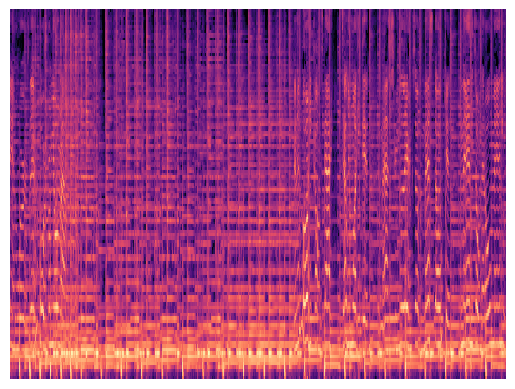

In [6]:
# DEMO
predict("country_heading-south")